# Comparing the fidelity of different decompositions methods
- **Authors:** Andrea Barletta, Yanlong Wang
- **Abstract:** In our project we will compare the fidelity of three different architectures for universal multiport interferometers, used to perform any unitary or linear transformation. In particular we will focus on comparing the traditional Reck and Clements architectures with a Universal Generalized Mach–Zehnder Interferometer (UGMZI) architecture inired by the work of P. Dita 

## Global stuff

### Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from circuit.interferometer import interferometer as itf
from circuit.component import component as cmp
from circuit.component import component_type as cmp_type

### Utils

In [17]:
# Set seed globally for reproducibility
np.random.seed(42)

# Function to generate a random unitary matrix of size N x N
def random_unitary(N):
    X = np.zeros([N, N], dtype=np.complex128)
    for ii in range(N):
        for jj in range(N):
            X[ii, jj] = (np.random.normal() + 1j * np.random.normal()) / np.sqrt(2)

    q, r = np.linalg.qr(X)
    r = np.diag(np.divide(np.diag(r), abs(np.diag(r))))
    U = np.matmul(q, r)

    return U

# Function to get arctangent of the absolute ratio of two numbers
def my_atan(x1, x2):
    if x2 != 0:
        return np.arctan(abs(x1/x2))
    else:
        return np.pi/2

# Function to get the angle of the ratio of two complex numbers
def my_angle(x1, x2):
    if x2 != 0:
        return np.angle(x1/x2)
    else:
        return 0

## Reck's Method
**References**

Reck, Michael, et al. "Experimental realization of any discrete unitary operator." Physical review letters 73.1 (1994): 58.    

Given a Unitary NxN matrix, we will decompose it to obtain the following circuit topology 

<p align="center">
    <img src="reck.png" width="50%"/>
</p>

We will also add a line of phase shifters at the end to achieve aritrary phase at the output (note that the values of the phase shifters are implicitly computed by the decomposition method)

- **Elimination Order:** 
  From the loop order and modes selected, we can find the elimination order is from top to bottom for all the rows (N-1 rows totally), right to left for columns within each row (numbers is from N-1 to 1).

- **Total number of beam splitters:** 
  The total number of beam splitters is $\frac{N(N-1)}{2}$, derived by adding from $1$ to $(N-1)$.

- **Determination of the phi and theta parameters:** The phi and theta parameters for each beam splitter are determined by elimination conditions derived from the unitary matrix. We have inverse T matrices like this:

    $$
    T^{-1}_{m,n}(\theta, \phi) = 
    \begin{bmatrix}
    1 & 0 & \cdots &        &        &        & 0 \\
    0 & 1 & \cdots &        &        &        & 0 \\
    \vdots & \vdots & \ddots &        &        &        & \vdots \\
          &        &        & e^{- i \phi}\cos\theta & e^{- i \phi} \sin\theta &        & \\
          &        &        & - \sin\theta & \cos\theta &        & \\
          &        &        &        &        & \ddots & \vdots \\
    0 & 0 & \cdots &        &        & \cdots & 1
    \end{bmatrix}
    $$

    Because for the corresponding row we want column $n$ (right one) to be 0, so we can compute the theta and phi parameters by using the following equations :
    $$
    x_n \cos\theta - x_m e^{-i\phi} \sin\theta = 0
    $$
    After some calculations, we can derive the following values for theta and phi:
    $$
    \begin{aligned}
        \theta &= \arctan \left( \left| \frac{x_n}{x_m} \right| \right) \\
        \phi   &= -\arg \left( -\frac{x_n}{x_m} \right)
    \end{aligned}
    $$

In [18]:
def decompose_reck(U):
    I = itf()
    N = int(np.sqrt(U.size))
    # Loop over each layer in the Reck triangular decomposition
    for i in range(N-1):
        # Each layer acts on a decreasing number of modes
        for j in range(N-1-i):
            modes = [N - j - 1, N - j]
            # Calculate the theta and phi for the inverse T matrix
            theta = my_atan(U[i, N - 1 - j], U[i, N - 2 - j])
            phi = -my_angle(-U[i, N - 1 - j], U[i, N - 2 - j])
            invT = np.eye(N, dtype=np.complex128)
            # Fill in the inverse T matrix based on the previous results
            invT[modes[0]-1, modes[0]-1] = np.exp(-1j * phi) * np.cos(theta)
            invT[modes[0]-1, modes[1]-1] = np.exp(-1j * phi) * np.sin(theta)
            invT[modes[1]-1, modes[0]-1] = -np.sin(theta)
            invT[modes[1]-1, modes[1]-1] = np.cos(theta)
            # Apply the inverse T matrix to the unitary matrix from right (affect 2 columns of U)
            U = np.matmul(U, invT)
            # Print to verify matrix after applying the inverse T matrix each step
            print(np.round(U, 2))
            I.comp_list.append(cmp(cmp_type.BEAM_SPLITTER, (modes), (theta, phi)))
            for mode in modes:
                I.comp_list.append(cmp(cmp_type.LOSS_ELEMENT, (mode,), ()))
            # Add a loss term
    phases = np.diag(U)
    I.output_phases = [np.angle(i) for i in phases]
    return I

Once we have our Reck decomposition function, we can use the interferometer $.calculate\_transformation()$ method to compute the reconstructed unitary, accounting for losses for each node

For example:

[[ 0.33-0.09j  0.11+0.56j -0.74-0.12j  0.  +0.j  ]
 [-0.32+0.36j  0.31-0.08j -0.18-0.15j -0.58+0.53j]
 [-0.68+0.21j  0.04-0.14j -0.42-0.11j  0.47-0.25j]
 [-0.37+0.07j -0.42+0.62j  0.16+0.42j  0.06+0.31j]]
[[ 0.33-0.09j  0.93+0.14j -0.  -0.j    0.  +0.j  ]
 [-0.32+0.36j  0.16-0.07j -0.08-0.34j -0.58+0.53j]
 [-0.68+0.21j  0.26+0.03j -0.34-0.13j  0.47-0.25j]
 [-0.37+0.07j  0.13+0.03j  0.44+0.74j  0.06+0.31j]]
[[-0.99-0.15j  0.  +0.j   -0.  -0.j    0.  +0.j  ]
 [ 0.  +0.j    0.47-0.21j -0.08-0.34j -0.58+0.53j]
 [ 0.  -0.j    0.75+0.1j  -0.34-0.13j  0.47-0.25j]
 [ 0.  +0.j    0.39+0.09j  0.44+0.74j  0.06+0.31j]]
[[-0.99-0.15j  0.  +0.j   -0.  -0.j    0.  -0.j  ]
 [ 0.  +0.j    0.47-0.21j  0.63-0.58j  0.  +0.j  ]
 [ 0.  -0.j    0.75+0.1j  -0.45+0.08j  0.15-0.44j]
 [ 0.  +0.j    0.39+0.09j -0.24+0.02j -0.37+0.8j ]]
[[-0.99-0.15j  0.  +0.j   -0.  -0.j    0.  -0.j  ]
 [ 0.  +0.j   -0.74+0.67j  0.  +0.j    0.  +0.j  ]
 [ 0.  -0.j   -0.  -0.j   -0.87+0.16j  0.15-0.44j]
 [ 0.  +0.j    0.  +0.j   -

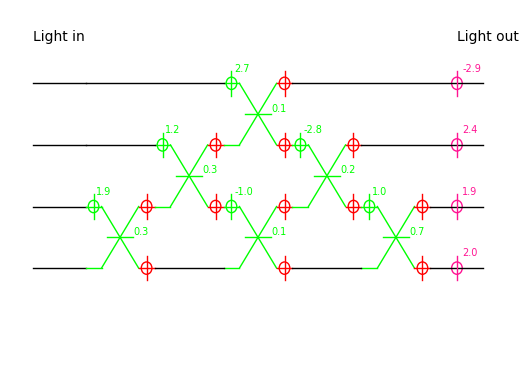

Frobenius norm: 5.113169173326532e-16


In [19]:
U = random_unitary(4)
I = decompose_reck(U)
I.draw()

Uexp = I.calculate_transformation()

print("Frobenius norm:", np.linalg.norm(Uexp - U))

## Clements' Method
**References**

Clements, William R., et al. "Optimal design for universal multiport interferometers." Optica 3.12 (2016): 1460-1465.


Given a Unitary NxN matrix, we will decompose it to obtain the following circuit topology 

<p align="center">
    <img src="clements.png" width="50%"/>
</p>

As with the Reck's decomposition, we will also add a line of phase shifters at the end to achieve aritrary phase at the output (also here, the values of the phase shifters are implicitly computed by the decomposition method)

The main difference with the Reck's method is that the Clements' method uses both T from left effecting the rows and T-inverse matrices from the right effecting the columns, so we have a different elimination order.

- **Elimination Order:** 
  For matrix T applying from left, the elimination order for rows is from top to bottom along the off-diagonal sequence. For matrix T-inverse applying from right, the elimination order for columns is from right to left along the off-diagonal sequence.

- **Total number of beam splitters:** 
  The total number of beam splitters is $\frac{N(N-1)}{2}$, which is same as Reck's method but having better topology.

- **Determination of the phi and theta parameters:** The phi and theta parameters for T and T-inverse matrices are determined by elimination conditions derived from the unitary matrix. We have matrices like this if we only focuse on the meaningful submatrix $T$ and $T^{-1}$ for simplicity:
    - $T$ matrix is applied from left and should make the bottom row zero:
      $$
      T(\theta, \phi) =
      \begin{bmatrix}
      e^{i\phi}\cos\theta & -\sin\theta \\
      e^{i\phi}\sin\theta & \cos\theta
      \end{bmatrix}
      $$

      By the equation below, we can derive the values for theta and phi:
      $$
      x_1 e^{i\phi} \sin\theta + x_2 \cos\theta = 0
      $$
      $$
      \begin{aligned}
          \theta &= \arctan \left( \left| \frac{x_2}{x_1} \right| \right) \\
          \phi   &= \arg \left( -\frac{x_2}{x_1} \right)
      \end{aligned}
      $$

    - $T^{-1}$ matrix is applied from right and should make the left column zero:
      $$
      T^{-1}(\theta, \phi) =
      \begin{bmatrix}
      e^{-i\phi}\cos\theta & e^{-i\phi}\sin\theta \\
      -\sin\theta & \cos\theta
      \end{bmatrix}
      $$
      By the equation below, we can derive the values for theta and phi:
      $$
      x_1 e^{-i\phi} \cos\theta - x_2 \sin\theta = 0
      $$
      $$
      \begin{aligned}
          \theta &= \arctan \left( \left| \frac{x_1}{x_2} \right| \right) \\
          \phi   &= \arg \left( \frac{x_1}{x_2} \right)
      \end{aligned}
      $$  

In [ ]:
def decompose_clements(U):
    I = itf()
    N = int(np.sqrt(U.size))
    left_T = []
    for i in range(N-1):
        # Determine if using T or T-inverse based on the layer index
        if np.mod(i, 2) == 0:
            for j in range(i+1):
                # The sequence is an offdiagonal shape, from right column elimination to left column elimination
                modes = [i - j + 1, i + 2 - j]
                # Calculate theta and phi for the T inverse matrix
                theta = my_atan(U[N-1-j, i-j], U[N-1-j, i-j+1])
                phi = my_angle(U[N-1-j, i-j], U[N-1-j, i-j+1])
                invT = np.eye(N, dtype=np.complex128)
                invT[modes[0]-1, modes[0]-1] = np.exp(-1j * phi) * np.cos(theta)
                invT[modes[0]-1, modes[1]-1] = np.exp(-1j * phi) * np.sin(theta)
                invT[modes[1]-1, modes[0]-1] = -np.sin(theta)
                invT[modes[1]-1, modes[1]-1] = np.cos(theta)
                # Apply the inverse T matrix to the unitary matrix from right (affect 2 columns of U)
                U = np.matmul(U, invT)
                print(np.round(U, 2))
                I.comp_list.append(cmp(cmp_type.BEAM_SPLITTER, (modes), (theta, phi)))
                for mode in modes:
                    I.comp_list.append(cmp(cmp_type.LOSS_ELEMENT, (mode,), ()))
        else:
            for j in range(i+1):
                # The sequence is an offdiagonal shape, from top row elimination to bottom row elimination
                modes = [N+j-i-1, N+j-i]
                # Calculate theta and phi for the T matrix
                theta = my_atan(U[N+j-i-1, j], U[N+j-i-2, j])
                phi = my_angle(-U[N+j-i-1, j], U[N+j-i-2, j])
                T = np.eye(N, dtype=np.complex128)
                T[modes[0]-1, modes[0]-1] = np.exp(1j * phi) * np.cos(theta)
                T[modes[0]-1, modes[1]-1] = -np.sin(theta)
                T[modes[1]-1, modes[0]-1] = np.exp(1j * phi) * np.sin(theta)
                T[modes[1]-1, modes[1]-1] = np.cos(theta)
                # Apply the T matrix to the unitary matrix from left (affect 2 rows of U)
                U = np.matmul(T, U)
                print(np.round(U, 2))
                left_T.append(cmp(cmp_type.BEAM_SPLITTER, (modes), (theta, phi)))

    for comp in np.flip(left_T, 0):
        modes = [int(comp.modes[0]), int(comp.modes[1])]
        invT = np.eye(N, dtype=np.complex128)
        invT[modes[0]-1, modes[0]-1] = np.exp(-1j * comp.params[1]) * np.cos(comp.params[0])
        invT[modes[0]-1, modes[1]-1] = np.exp(-1j * comp.params[1]) * np.sin(comp.params[0])
        invT[modes[1]-1, modes[0]-1] = -np.sin(comp.params[0])
        invT[modes[1]-1, modes[1]-1] = np.cos(comp.params[0])
        U = np.matmul(invT, U)
        theta = my_atan(U[modes[1]-1, modes[0]-1], U[modes[1]-1, modes[1]-1])
        phi = my_angle(U[modes[1]-1, modes[0]-1], U[modes[1]-1, modes[1]-1])
        invT[modes[0]-1, modes[0]-1] = np.exp(-1j * phi) * np.cos(theta)
        invT[modes[0]-1, modes[1]-1] = np.exp(-1j * phi) * np.sin(theta)
        invT[modes[1]-1, modes[0]-1] = -np.sin(theta)
        invT[modes[1]-1, modes[1]-1] = np.cos(theta)
        U = np.matmul(U, invT)
        I.comp_list.append(cmp(cmp_type.BEAM_SPLITTER, (modes), (theta, phi)))
        for mode in modes:
                I.comp_list.append(cmp(cmp_type.LOSS_ELEMENT, (mode,), ()))
    phases = np.diag(U)
    I.output_phases = [np.angle(i) for i in phases]
    return I

Once we have our Clements decomposition function, we can use the interferometer $.calculate\_transformation()$ method to compute the reconstructed unitary, accounting for losses for each node

For example:

[[ 0.49+0.18j  0.45-0.04j  0.71+0.1j   0.05+0.05j]
 [ 0.38+0.23j -0.25+0.29j -0.16-0.19j  0.77-0.09j]
 [ 0.7 +0.19j -0.22-0.16j -0.39+0.05j -0.47+0.14j]
 [-0.  -0.j    0.68+0.34j -0.39-0.34j -0.03+0.4j ]]
[[ 0.49+0.18j  0.45-0.04j  0.71+0.1j   0.05+0.05j]
 [-0.82-0.23j  0.27-0.05j  0.44+0.03j  0.03+0.03j]
 [-0.  +0.j    0.02-0.38j -0.02+0.15j -0.86+0.31j]
 [-0.  -0.j    0.68+0.34j -0.39-0.34j -0.03+0.4j ]]
[[ 0.49+0.18j  0.45-0.04j  0.71+0.1j   0.05+0.05j]
 [-0.82-0.23j  0.27-0.05j  0.44+0.03j  0.03+0.03j]
 [ 0.  +0.j   -0.76-0.38j  0.4 +0.34j  0.01+0.05j]
 [-0.  +0.j    0.  +0.j   -0.06-0.08j -0.06+0.99j]]
[[ 0.49+0.18j  0.45-0.04j -0.48-0.55j -0.  -0.j  ]
 [-0.82-0.23j  0.27-0.05j -0.32-0.31j -0.  +0.j  ]
 [ 0.  +0.j   -0.76-0.38j -0.08-0.52j -0.  +0.j  ]
 [-0.  +0.j    0.  +0.j    0.  +0.j   -0.06+1.j  ]]
[[ 0.49+0.18j  0.56+0.64j -0.  -0.j   -0.  -0.j  ]
 [-0.82-0.23j  0.37+0.36j -0.  +0.j   -0.  +0.j  ]
 [ 0.  +0.j    0.  +0.j   -0.16-0.99j -0.  +0.j  ]
 [-0.  +0.j    0.  +0.j    

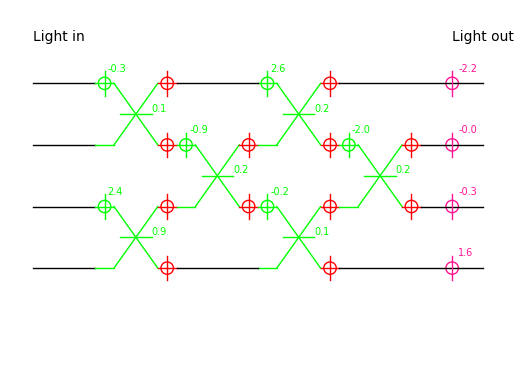

Frobenius norm: 1.3984269514031156


In [22]:
U = random_unitary(4)
I = decompose_clements(U)
I.draw()
Uexp = I.calculate_transformation(LN_dB=-1.5)

print("Frobenius norm:", np.linalg.norm(Uexp - U))

## UGMZI Decomposition
**References**

P. Dita, J. Phys. A: Math. Gen. 2006, 36, 2781.

In this decomposition, inspired by P.Dita, we will decompose a unitary matrix U in the form
$$
 U = d_n\mathcal{O}_nd_{n-1}^1\mathcal{O}_{n-1}^1\dots d_{2}^{n-2}\mathcal{O}_2^{n-2}d_1^{n-1}
$$

Where the $d_k$ matrices are diagonal matrices with the last $k$ elements equal to $e^{i\varphi_l}$, and the $\mathcal{O}_{n-k}^k$ matrices are obtained by multiplying Givens rotations as follows

$$
\mathcal{O}_{n-k} = J_{n-k-1,n-k}J_{n-k-2,n-k-1}\dots J_{1,2}
$$

and extendeted to dimension $n$ by placing them in the bottom-right corner of an identity matrix, that is

$$
\mathcal{O}_{n-k}^k = \begin{bmatrix} I_k & 0 \\ 0 & O_{n-k}\end{bmatrix}
$$

The implementation with the photonic circuit is immediate, using a column of phase shifter for the $d$ matrices, and a cascade of beam splitters for the $O$ matrices

In [7]:
def decompose_ugmzi(U):
    N = int(np.sqrt(U.size))
    I = itf()
    # Notice that we will decompose from n->1, so we will have to insert the elements in the circuit in reverse order
    # Extract the output phases (we will add these at the end)
    phases = np.angle(U[:, 0])
    Dd = np.diag(np.exp(-1j*phases))
    U = Dd @ U
    I.output_phases = phases
    for n in range(N, 1, -1):
        # Compute the appropriate Givens rotations to have the matrix in the form [1 0; 0 U']
        for i in range(n-1, 0, -1):
            u = U[:, 0]
            theta = my_atan(u[i], u[i-1])
            O = np.eye(n, dtype=np.complex128)
            # theta = my_atan(u[j], u[j-1])
            O[i-1][i-1] = np.cos(theta)
            O[i-1][i] = np.sin(theta)
            O[i][i-1] = -np.sin(theta)
            O[i][i] = np.cos(theta)
            U = O @ U
            I.comp_list.insert(0,cmp(cmp_type.BEAM_SPLITTER, (N-n+i, N-n+i+1), (theta, 0)))
            I.comp_list.insert(1, cmp(cmp_type.LOSS_ELEMENT, (N-n+i,), ()))
            I.comp_list.insert(1, cmp(cmp_type.LOSS_ELEMENT, (N-n+i+1,), ()))

        # Resize the matrix U
        U = U[1:, 1:]
        
        # Extract the phases to make the first column real and positive
        phases = np.angle(U[:, 0])
        Dd = np.diag(np.exp(-1j*phases))
        U = Dd @ U
        phases = phases[::-1]
        for i in range(len(phases)):
            I.comp_list.insert(0,cmp(cmp_type.PHASE_SHIFTER, (N-i,), (phases[i],)))
            

    #Insert the loss related to the first block
    I.comp_list.insert(1, cmp(cmp_type.LOSS_ELEMENT, (N,), ()))
    return I

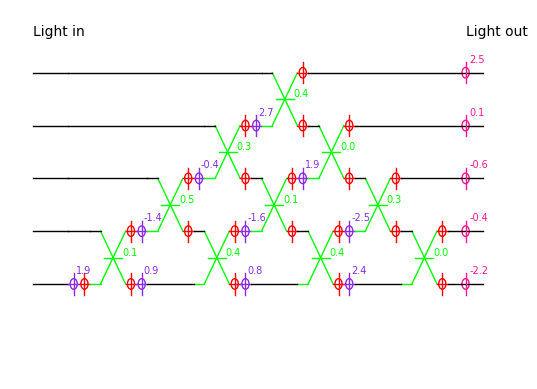

Frobenius norm: 6.515820893625098e-16


In [8]:
U = random_unitary(5)
I = decompose_ugmzi(U)
I.draw()

Uexp = I.calculate_transformation()

print("Frobenius norm:", np.linalg.norm(Uexp - U))

In [9]:
def fidelity_restorer(N,LN_dB):
    # Number of phase shifter (exluding final ones) on mode k = k-1
    # Number of BS on mode k = 2k-1, except for the last one which has N-1
    kn = 10**(-LN_dB/10)
    attenuation = np.array([], dtype=np.float64)
    for i in range(1,N):
        total_loss = kn**(2*i-1)
        print("Total loss for mode", i, ":", 1/total_loss)
        attenuation = np.append(attenuation, total_loss)

    attenuation = np.append(attenuation, 1/kn**(N-1))
    return attenuation

In [10]:
LN_dB = -1.5
U = random_unitary(3)
Uexp = decompose_ugmzi(U).calculate_transformation(LN_dB=LN_dB)
Thing = U.conj().T @ Uexp
print("Thing:", Thing)
# x = random_unitary(5)[0,:]
# y = U @ x
# yexp = Uexp @ x
# print("Output error:", np.linalg.norm(yexp - y)/np.linalg.norm(y))
# y_restored = Uexp @ np.diag(fidelity_restorer(5, LN_dB)) @ x
# print("Restored output error:", np.linalg.norm(y_restored - y)/np.linalg.norm(y))

Thing: [[1.36457429-5.55111512e-17j 0.09648767-1.75115921e-02j
  0.05697375-4.50056744e-03j]
 [0.08118426+1.47341685e-02j 1.45849202+0.00000000e+00j
  0.02664639+2.69256616e-03j]
 [0.04033433+3.18615775e-03j 0.02242014-2.26551209e-03j
  1.69193692+5.55111512e-17j]]


## Fidelity Comparison

In [11]:
def Fid(Uid, Uexp):
    return np.abs(np.trace(Uid @ Uexp.conj().T) / 
      np.sqrt(
          np.trace(Uid @ Uid.conj().T)*np.trace(Uexp @ Uexp.conj().T)
      ))**2

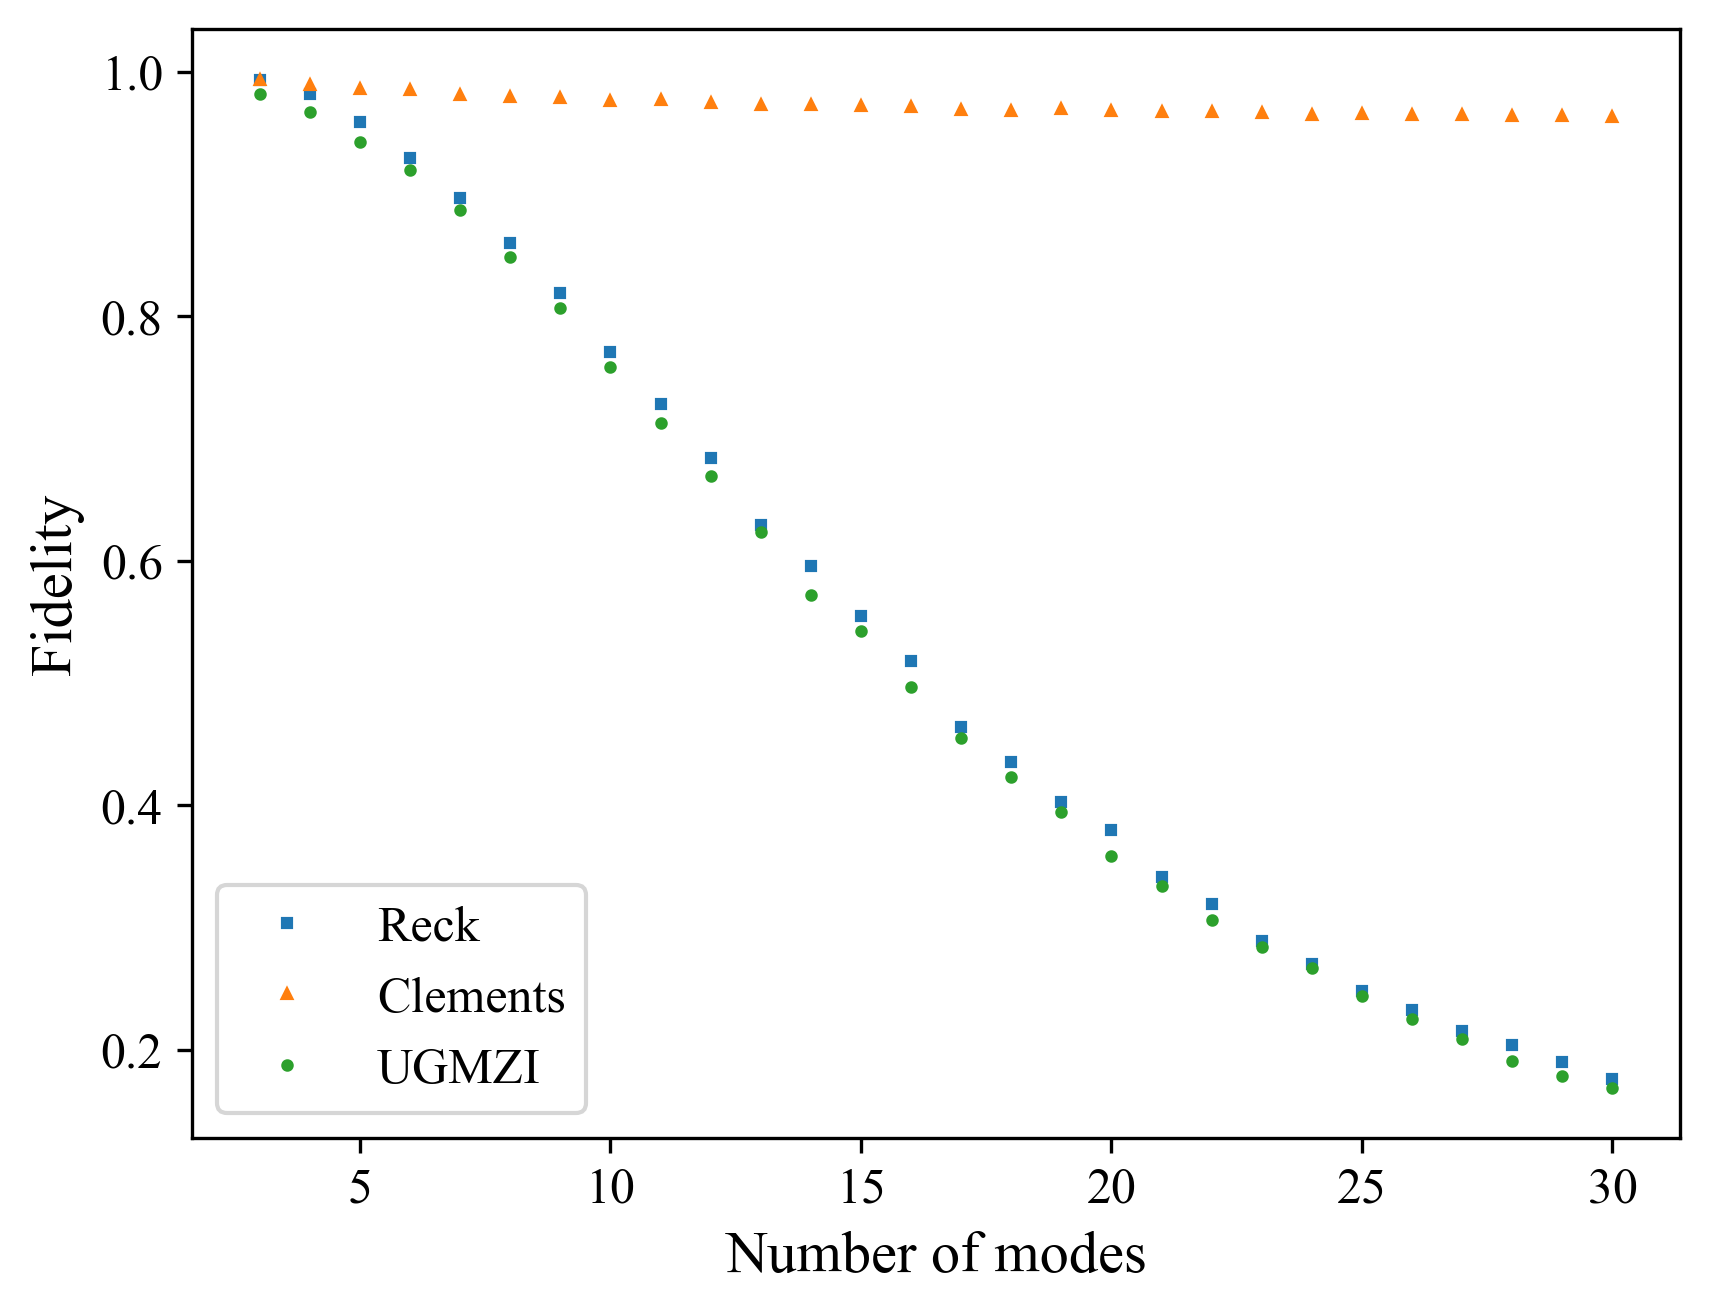

In [12]:
# System Configurations and Parameters
NUM_MODE = 31
LN_dB=-1.5
COUNT = 30

# Buffers to store the data for drawings
fidelity = np.zeros((NUM_MODE, 1))

# Setup for Matplotlib
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["font.size"] = 12
plt.figure(dpi=300)
x = range(3, NUM_MODE)

# Sweep Parameters [Reck]
for i in range(3, NUM_MODE):
    total = 0.0
    for _ in range(COUNT):
        U = random_unitary(i)
        circuit = decompose_reck(U)
        Uexp = circuit.calculate_transformation(LN_dB=LN_dB)
        total += Fid(U, Uexp)
    fidelity[i] = total / COUNT

# Annotate Setup
y_reck = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_reck, 's', markersize=2)

# Sweep Parameters [Clements]
for i in range(3, NUM_MODE):
    total = 0.0
    for _ in range(COUNT):
        U = random_unitary(i)
        circuit = decompose_clements(U)
        Uexp = circuit.calculate_transformation(LN_dB=LN_dB)
        total += Fid(U, Uexp)
    fidelity[i] = total / COUNT

# Annotate Setup
y_clements = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_clements, '^', markersize=2)

# Sweep Parameters [UGMZI]
for i in range(3, NUM_MODE):
    total = 0.0
    for _ in range(COUNT):
        U = random_unitary(i)
        circuit = decompose_ugmzi(U)
        Uexp = circuit.calculate_transformation(LN_dB=LN_dB)
        total += Fid(U, Uexp)
    fidelity[i] = total / COUNT

# Annotate Setup
y_ugmzi = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_ugmzi, 'o', markersize=2)

# Decorate Figures
plt.xlabel('Number of modes', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.legend(['Reck', 'Clements', 'UGMZI'])

plt.show()